In [ ]:
'''
 * Copyright (c) 2017 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

##  More on the Lasso and Related Path Algorithms

Since the publication of the LAR algorithm (Efron et al., 2004), there has been a lot of activity in developing algorithms for fitting regularization paths for a variety of different problems. In addition, L1 regularization has gained prominence, leading to the development of the field of compressed sensing in the signal-processing literature (Donoho, 2006a; Candes, 2006).

In this section, we discuss some related proposals and other path algorithms, starting off with a precursor to the LAR algorithm.

### Incremental Forward Stagewise Regression

Here we present another LAR-like algorithm, this time focused on forward stagewise regression. Interestingly, efforts to understand a flexible nonlinear regression procedure (boosting) led to a new algorithm for linear models (LAR).

#### Algorithm : Incremental Forward Stagewise Regression — FS$_\epsilon$

1. Start with the residual $r$ equal to $y$, and $\beta_1, \beta_2, \dots, \beta_p = 0$. All the predictors are standardized to have mean zero and unit norm.
2. Find the predictor $x_j$ most correlated with $r$.
3. Update $\beta_j \leftarrow \beta_j + \delta_j$, where $\delta_j = \epsilon \cdot \text{sign}(\langle x_j, r \rangle)$, and $\epsilon > 0$ is a small step size. Set $r \leftarrow r - \delta_j x_j$.
4. Repeat steps 2 and 3 many times, until the residuals are uncorrelated with all the predictors.

Figure 3.19 shows the coefficient profiles for the prostate data:

- The left panel shows incremental forward stagewise regression with step size $\epsilon = 0.01$.
- The right panel shows the infinitesimal version FS$_0$ obtained by letting $\epsilon \to 0$.

This profile was fit by the modification 3.2b to the LAR Algorithm 3.2. In this example, the FS$_0$ profiles are monotone and hence identical to those of lasso and LAR.

### Algorithm : Least Angle Regression — FS$_0$ Modification

1. Find the new direction by solving the constrained least squares problem:

$$
\min \|r - X_A b\|_2^2 \quad \text{subject to} \quad b_j s_j \geq 0, \ j \in A,
$$

where $s_j$ is the sign of $\langle x_j, r \rangle$. The modification amounts to a non-negative least squares fit, keeping the signs of the coefficients the same as those of the correlations.

One can show that this achieves the optimal balancing of infinitesimal "update turns" for the variables tied for maximal correlation (Hastie et al., 2007). Like lasso, the entire FS$_0$ path can be computed very efficiently via the LAR algorithm.

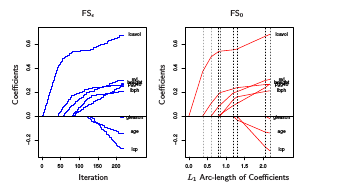

Fig. 1. Coeﬃcient proﬁles for the prostate data. The left panel shows incremental forward stagewise regression with step size ǫ = 0.01. The right panel shows the inﬁnitesimal version FS0 obtained letting ǫ → 0. This proﬁle was ﬁt by the modiﬁcation 3.2b to the LAR Algorithm 3.2. In this example the FS0 proﬁles are monotone, and hence identical to those of lasso and LAR.

The modiﬁcation amounts to a non-negative least squares ﬁt, keeping the signs of the coeﬃcients the same as those of the correlations. One can show that this achieves the optimal balancing of inﬁnitesimal “update turns” for the variables tied for maximal correlation (Hastie et al., 2007). Like lasso, the entire FS0 path can be computed very eﬃciently via the LAR algorithm. As a consequence of these results, if the LAR proﬁles are monotone non- increasing or non-decreasing, as they are in Figure 3.19, then all three methods—LAR, lasso, and FS0 —give identical proﬁles. If the proﬁles are not monotone but do not cross the zero axis, then LAR and lasso are identical. Since FS0 is diﬀerent from the lasso, it is natural to ask if it optimizes a criterion. The answer is more complex than for lasso; the FS0 coeﬃcient proﬁle is the solution to a diﬀerential equation. While the lasso makes op- timal progress in terms of reducing the residual sum-of-squares per unit increase in L1 -norm of the coeﬃcient vector β, FS0 is optimal per unit increase in L1 arc-length traveled along the coeﬃcient path. Hence its co- eﬃcient path is discouraged from changing directions too often. FS0 is more constrained than lasso, and in fact can be viewed as a mono- tone version of the lasso; see Figure 16.3 on page 614 for a dramatic exam- ple. FS0 may be useful in p ≫ N situations, where its coeﬃcient proﬁles are much smoother and hence have less variance than those of lasso. More details on FS0 are given in Section 16.2.3 and Hastie et al. (2007). Fig- ure 3.16 includes FS0 where its performance is very similar to that of the lasso.


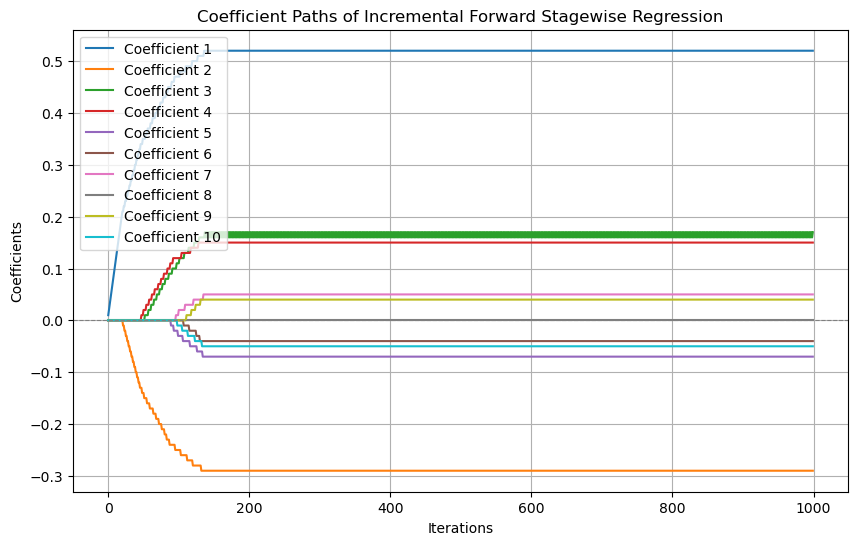

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV

# Generate synthetic data
np.random.seed(0)
n_samples, n_features = 100, 10
X = np.random.randn(n_samples, n_features)
true_coefficients = np.array([0.5, -0.3, 0.2, 0, 0, 0, 0, 0, 0, 0])  # Only first three are non-zero
y = X @ true_coefficients + np.random.randn(n_samples) * 0.5  # Add noise

# Standardize predictors
X_standardized = (X - X.mean(axis=0)) / X.std(axis=0)

# Incremental Forward Stagewise Regression
def incremental_forward_stagewise_regression(X, y, epsilon=0.01, max_iterations=1000):
    n_samples, n_features = X.shape
    coefficients = np.zeros(n_features)
    residuals = y.copy()
    coeff_history = []

    for _ in range(max_iterations):
        correlations = X.T @ residuals  # Calculate correlations
        j = np.argmax(np.abs(correlations))  # Most correlated predictor
        delta_j = epsilon * np.sign(correlations[j])  # Update step
        coefficients[j] += delta_j
        residuals -= delta_j * X[:, j]
        coeff_history.append(coefficients.copy())

    return np.array(coeff_history)

# Run the incremental forward stagewise regression
coeff_history = incremental_forward_stagewise_regression(X_standardized, y)

# Plotting the coefficient paths
plt.figure(figsize=(10, 6))
for i in range(coeff_history.shape[1]):
    plt.plot(coeff_history[:, i], label=f'Coefficient {i + 1}')

plt.title('Coefficient Paths of Incremental Forward Stagewise Regression')
plt.xlabel('Iterations')
plt.ylabel('Coefficients')
plt.axhline(0, color='gray', linestyle='--', lw=0.8)
plt.legend()
plt.grid()
plt.show()


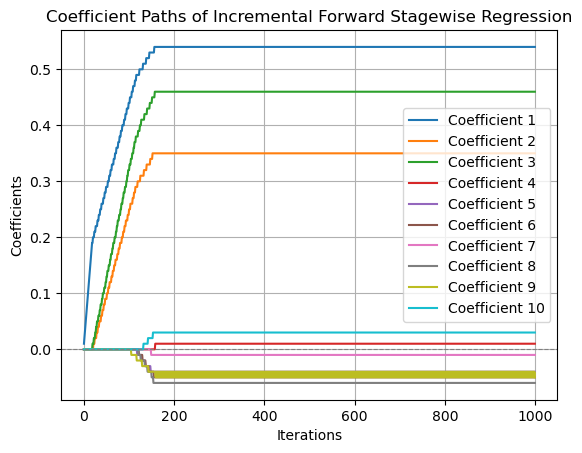

In [2]:
import random
import math

# Step 1: Generate synthetic data
def generate_data(n_samples, n_features):
    # Generate random coefficients
    true_coefficients = [0.5 if i < 3 else 0 for i in range(n_features)]
    true_coefficients = [round(coef, 2) for coef in true_coefficients]

    # Generate samples
    X = []
    y = []
    for _ in range(n_samples):
        x_row = [random.gauss(0, 1) for _ in range(n_features)]
        X.append(x_row)
        # Calculate y with some noise
        noise = random.gauss(0, 0.5)
        y_value = sum(coef * x for coef, x in zip(true_coefficients, x_row)) + noise
        y.append(round(y_value, 2))

    return X, y

# Step 2: Implement Incremental Forward Stagewise Regression
def incremental_forward_stagewise_regression(X, y, epsilon=0.01, max_iterations=1000):
    n_samples = len(X)
    n_features = len(X[0])
    coefficients = [0.0] * n_features
    residuals = y[:]  # Copy of y
    coeff_history = []  # To record coefficients at each iteration

    for _ in range(max_iterations):
        # Calculate correlations
        correlations = [0.0] * n_features
        for j in range(n_features):
            correlations[j] = sum(X[i][j] * residuals[i] for i in range(n_samples))

        # Find the most correlated predictor
        j = correlations.index(max(correlations, key=abs))
        delta_j = epsilon * (1 if correlations[j] > 0 else -1)  # Update step
        coefficients[j] += delta_j

        # Update residuals
        for i in range(n_samples):
            residuals[i] -= delta_j * X[i][j]

        coeff_history.append(coefficients.copy())

    return coeff_history

# Step 3: Plotting the Coefficients
def plot_coefficients(coeff_history):
    max_iterations = len(coeff_history)
    n_features = len(coeff_history[0])
    for i in range(n_features):
        plt.plot(range(max_iterations), [coeff_history[j][i] for j in range(max_iterations)], label=f'Coefficient {i + 1}')

    plt.title('Coefficient Paths of Incremental Forward Stagewise Regression')
    plt.xlabel('Iterations')
    plt.ylabel('Coefficients')
    plt.axhline(0, color='gray', linestyle='--', lw=0.8)
    plt.legend()
    plt.grid()
    plt.show()

# Generate data and run the regression
n_samples = 100
n_features = 10
X, y = generate_data(n_samples, n_features)
coeff_history = incremental_forward_stagewise_regression(X, y)

# Plotting the coefficient paths
plot_coefficients(coeff_history)


## Piecewise-Linear Path Algorithms

The least angle regression procedure exploits the piecewise linear nature of the lasso solution paths. It has led to similar “path algorithms” for other regularized problems. Suppose we solve 

$$
\hat{\beta}(\lambda) = \arg\min_{\beta} \left[ R(\beta) + \lambda J(\beta) \right], \tag{3.76}
$$

with

$$
R(\beta) = \sum_{i=1}^{N} L(y_i, \beta_0 + \sum_{j=1}^{p} x_{ij} \beta_j), \tag{3.77}
$$

where both the loss function $ L $ and the penalty function $ J $ are convex. Then the following are sufficient conditions for the solution path $ \hat{\beta}(\lambda) $ to be piecewise linear (Rosset and Zhu, 2007):

1. $ R $ is quadratic or piecewise-quadratic as a function of $ \beta $.
2. $ J $ is piecewise linear in $ \beta $.

This also implies (in principle) that the solution path can be efficiently computed. Examples include squared- and absolute-error loss, “Huberized” losses, and the $ L_1 $, $ L_\infty $ penalties on $ \beta $. Another example is the “hinge loss” function used in the support vector machine. There, the loss is piecewise linear, and the penalty is quadratic. Interestingly, this leads to a piecewise-linear path algorithm in the dual space; more details are given in next section .

##  The Dantzig Selector

Candes and Tao (2007) proposed the following criterion:

$$
\min_{\beta} ||\beta||_1 \quad \text{subject to} \quad ||X^T (y - X\beta)||_\infty \leq s. \tag{3.78}
$$

They call the solution the Dantzig selector (DS). It can be written equivalently as

$$
\min_{\beta} ||X^T (y - X\beta)||_\infty \quad \text{subject to} \quad ||\beta||_1 \leq t. \tag{3.79}
$$

Here $ || \cdot ||_\infty $ denotes the $ L_\infty $ norm, the maximum absolute value of the components of the vector. In this form, it resembles the lasso, replacing squared error loss by the maximum absolute value of its gradient. Note that as $ t $ gets large, both procedures yield the least squares solution if $ N < p $. If $ p \geq N $, they both yield the least squares solution with minimum $ L_1 $ norm. However, for smaller values of $ t $, the DS procedure produces a different path of solutions than the lasso. Candes and Tao (2007) show that the solution to DS is a linear programming problem; hence the name Dantzig selector, in honor of the late George Dantzig.

George Dantzig, the inventor of the simplex method for linear program- ming. They also prove a number of interesting mathematical properties for the method, related to its ability to recover an underlying sparse coeﬃ- cient vector. These same properties also hold for the lasso, as shown later by Bickel et al. (2008). Unfortunately the operating properties of the DS method are somewhat unsatisfactory. The method seems similar in spirit to the lasso, especially when we look at the lasso’s stationary conditions (3.58). Like the LAR al- gorithm, the lasso maintains the same inner product (and correlation) with the current residual for all variables in the active set, and moves their co- eﬃcients to optimally decrease the residual sum of squares. In the process, this common correlation is decreased monotonically (Exercise 3.23), and at all times this correlation is larger than that for non-active variables. The Dantzig selector instead tries to minimize the maximum inner product of the current residual with all the predictors. Hence it can achieve a smaller maximum than the lasso, but in the process a curious phenomenon can occur. If the size of the active set is m, there will be m variables tied with maximum correlation. However, these need not coincide with the active set! Hence it can include a variable in the model that has smaller correlation with the current residual than some of the excluded variables (Efron et al., 2007). This seems unreasonable and may be responsible for its some- times inferior prediction accuracy. Efron et al. (2007) also show that DS can yield extremely erratic coeﬃcient paths as the regularization parameter s is varied.


In [ ]:
import random

# Step 1: Generate synthetic data
def generate_data(n_samples, n_features):
    true_coefficients = [0.5 if i < 3 else 0 for i in range(n_features)]
    true_coefficients = [round(coef, 2) for coef in true_coefficients]

    X = []
    y = []
    for _ in range(n_samples):
        x_row = [random.gauss(0, 1) for _ in range(n_features)]
        X.append(x_row)
        noise = random.gauss(0, 0.5)
        y_value = sum(coef * x for coef, x in zip(true_coefficients, x_row)) + noise
        y.append(round(y_value, 2))

    return X, y

# Step 2: Implementing the Dantzig Selector
def dantzig_selector(X, y, s):
    n_samples = len(X)
    n_features = len(X[0])
    
    beta = [0.0] * n_features
    residuals = [y[i] - sum(X[i][j] * beta[j] for j in range(n_features)) for i in range(n_samples)]
    
    beta_history = []  # To store beta coefficients for plotting
    
    while True:
        correlations = [sum(X[i][j] * residuals[i] for i in range(n_samples)) for j in range(n_features)]
        
        # Store the current state of beta for plotting
        beta_history.append(beta[:])
        
        max_corr = max(abs(corr) for corr in correlations)
        max_index = correlations.index(max_corr if max_corr in correlations else -max_corr)

        if abs(correlations[max_index]) <= s:
            break

        beta[max_index] += (1 if correlations[max_index] > 0 else -1) * s

        # Update residuals
        for i in range(n_samples):
            residuals[i] -= (X[i][max_index] * (1 if correlations[max_index] > 0 else -1) * s)

    return beta, beta_history

# Step 3: Basic Plotting Function
def plot_coefficients(beta_history):
    n_iterations = len(beta_history)
    n_features = len(beta_history[0])

    # Print the plot
    print("Coefficients over iterations:")
    for j in range(n_features):
        y_coords = [beta[j] for beta in beta_history]

        # Simple text-based plotting
        print(f"Feature {j + 1}:")
        for i in range(n_iterations):
            # Scale the output for better visualization
            pos = int(y_coords[i] * 10)
            print(" " * (pos + 20) + "*")

# Step 4: Running the Dantzig Selector
n_samples = 100
n_features = 10
s = 1.0

X, y = generate_data(n_samples, n_features)
beta, beta_history = dantzig_selector(X, y, s)

# Output the result and plot
print("Estimated coefficients (Dantzig Selector):")
print(beta)

# Plot the coefficients
plot_coefficients(beta_history)


##  The Grouped Lasso

In some problems, the predictors belong to pre-defined groups; for example, genes that belong to the same biological pathway, or collections of indicator (dummy) variables for representing the levels of a categorical predictor. In this situation, it may be desirable to shrink and select the members of a group together. The grouped lasso is one way to achieve this.

Suppose that the $ p $ predictors are divided into $ L $ groups, with $ p_\ell $ the number in group $ \ell $. For ease of notation, we use a matrix $ X_\ell $ to represent the predictors corresponding to the $ \ell $-th group, with corresponding coefficient vector $ \beta_\ell $. The grouped lasso minimizes the convex criterion

$$
\min_{\beta \in \mathbb{R}^p} \left\{ \sum_{\ell=1}^L \left( \| y - \beta_0 \mathbf{1} - X_\ell \beta_\ell \|_2^2 + \lambda \sqrt{p_\ell} \|\beta_\ell\|_2 \right) \right\} 
$$

where the $ p_\ell $ terms account for the varying group sizes, and $ \| \cdot \|_2 \) is the Euclidean norm (not squared). 

Since the Euclidean norm of a vector $ \beta_\ell $ is zero only if all of its components are zero, this procedure encourages sparsity at both the group and individual levels. That is, for some values of $ \lambda $, an entire group of predictors may drop out of the model. 

This procedure was proposed by Bakin (1999) and Lin and Zhang (2006), and studied and generalized by Yuan and Lin (2007). Generalizations include more general \( L^2 \) norms \( \|\eta\|_K = \sqrt{\eta^T K \eta} \), as well as allowing overlapping groups of predictors (Zhao et al., 2008). There are also connections to methods for fitting sparse additive models (Lin and Zhang, 2006; Ravikumar et al., 2008).


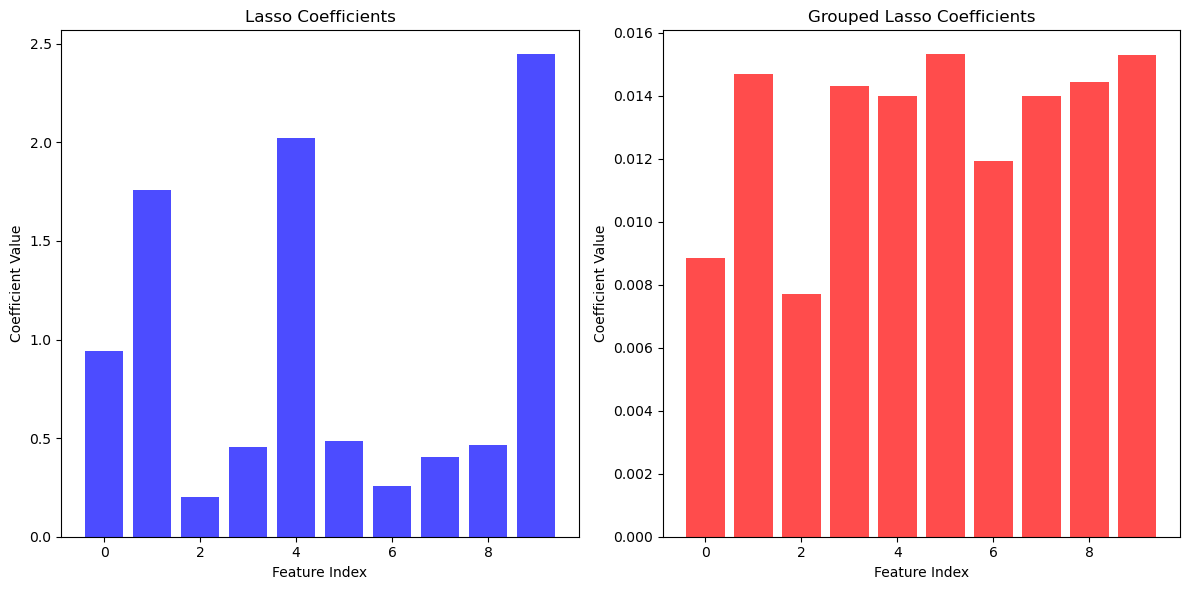

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Function to implement Lasso regression using gradient descent
def lasso_regression(X, y, lambda_reg, alpha=0.01, num_iters=1000):
    m, n = X.shape
    beta = np.zeros(n)
    
    for _ in range(num_iters):
        y_pred = X @ beta
        residual = y_pred - y
        
        # Gradient calculation
        gradient = (1/m) * (X.T @ residual) + lambda_reg * np.sign(beta)
        beta -= alpha * gradient
        
    return beta

# Function to implement Grouped Lasso regression
def grouped_lasso(X, y, lambda_reg, groups, alpha=0.01, num_iters=1000):
    m, n = X.shape
    beta = np.zeros(n)
    
    for _ in range(num_iters):
        y_pred = X @ beta
        residual = y_pred - y
        
        # Gradient calculation
        gradient = (1/m) * (X.T @ residual)
        
        # Grouped update
        for g in np.unique(groups):
            group_indices = np.where(groups == g)[0]
            group_beta = beta[group_indices]
            group_gradient = gradient[group_indices]
            
            # Update the group coefficients
            if np.linalg.norm(group_beta) > 0:
                beta[group_indices] -= alpha * group_gradient
                # Soft thresholding
                group_beta -= alpha * lambda_reg * np.sign(group_beta)
                group_beta = np.sign(group_beta) * np.maximum(0, np.abs(group_beta) - alpha * lambda_reg)
                beta[group_indices] = group_beta
            else:
                beta[group_indices] -= alpha * group_gradient

    return beta

# Generating synthetic data for demonstration
np.random.seed(42)
n_samples = 100
n_features = 10

X = np.random.rand(n_samples, n_features)
true_beta = np.array([1, 2, 0, 0, 3, 0, 0, 0, 0, 4])  # Sparse true coefficients
y = X @ true_beta + np.random.normal(0, 0.1, n_samples)

# Define groups for Grouped Lasso
groups = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3])

# Fit Lasso and Grouped Lasso
lambda_reg = 0.1
lasso_coefficients = lasso_regression(X, y, lambda_reg)
grouped_lasso_coefficients = grouped_lasso(X, y, lambda_reg, groups)

# Plotting the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(n_features), lasso_coefficients, color='b', alpha=0.7)
plt.title('Lasso Coefficients')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')

plt.subplot(1, 2, 2)
plt.bar(range(n_features), grouped_lasso_coefficients, color='r', alpha=0.7)
plt.title('Grouped Lasso Coefficients')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')

plt.tight_layout()
plt.show()


##  Further Properties of the Lasso

A number of authors have studied the ability of the lasso and related procedures to recover the correct model, as $ N $ and $ p $ grow. Examples of this work include Knight and Fu (2000), Greenshtein and Ritov (2004), Tropp (2004), Donoho (2006b), Meinshausen (2007), Meinshausen and Bühlmann (2006), Tropp (2006), Zhao and Yu (2006), Wainwright (2006), and Bunea et al. (2007). For example, Donoho (2006b) focuses on the $p > N $ case and considers the lasso solution as the bound $ t $ gets large. In the limit, this gives the solution with minimum $ L_1 $ norm among all models with zero training error. 

He shows that under certain assumptions on the model matrix $ X $, if the true model is sparse, this solution identifies the correct predictors with high probability. Many of the results in this area assume a condition on the model matrix of the form 

$$
\max_{j \in S} ||x_j^T X_S (X_S^T X_S)^{-1}||_1 \leq (1 - \epsilon) \text{ for some } \epsilon \in (0, 1]
$$

Here, $ S $ indexes the subset of features with non-zero coefficients in the true underlying model, and $ X_S $ are the columns of $ X $ corresponding to those features. Similarly, $ S^c $ are the features with true coefficients equal to zero, and $ X_{S^c} $ the corresponding columns. This says that the least squares coefficients for the columns of $ X_{S^c} $ on $ X_S $ are not too large, that is, the “good” variables $ S $ are not too highly correlated with the nuisance variables $ S^c $.

Regarding the coefficients themselves, the lasso shrinkage causes the estimates of the non-zero coefficients to be biased towards zero, and in general they are not consistent. One approach for reducing this bias is to run the lasso to identify the set of non-zero coefficients, and then fit an unrestricted linear model to the selected set of features. This is not always feasible if the selected set is large. 

Alternatively, one can use the lasso to select the set of non-zero predictors and then apply the lasso again, but using only the selected predictors from the first step. This is known as the relaxed lasso (Meinshausen, 2007). The idea is to use cross-validation to estimate the initial penalty parameter for the lasso, and then again for a second penalty parameter applied to the selected set of predictors. 

Since the variables in the second step have less “competition” from noise variables, cross-validation will tend to pick a smaller value for $ \lambda $, and hence their coefficients will be shrunken less than those in the initial estimate. 

Alternatively, one can modify the lasso penalty function so that larger coefficients are shrunken less severely; the smoothly clipped absolute deviation (SCAD) penalty of Fan and Li (2005) replaces $ \lambda |\beta| $ by 

$$
J_a(\beta, \lambda) = 
\begin{cases} 
\lambda \cdot \text{sign}(\beta) & \text{if } |\beta| \leq \lambda \\ 
(a - 1)\lambda & \text{if } |\beta| > a\lambda 
\end{cases}
$$

for some $ a \geq 2 $. The second term in the square-braces reduces the amount of shrinkage in the lasso for larger values of $ \beta $, with ultimately no shrinkage as $ a \to \infty $. 

Fig. 2. shows the SCAD penalty, along with the lasso and $ |\beta|^{1 - \nu} $.

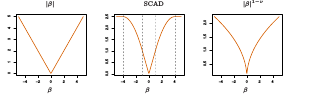

Fig. 2. The lasso and two alternative non-convex penalties designed to penalize large coeﬃcients less. For SCAD we use λ = 1 and a = 4, and ν = 12 in the last panel.

However, this criterion is non-convex, which is a drawback since it makes the computation much more difficult. The adaptive lasso (Zou, 2006) uses a weighted penalty of the form 

$$
\sum_{j=1}^{p} w_j |\beta_j| 
$$

where $ w_j = \frac{1}{|\hat{\beta}_j|^{\nu}} $, $ \hat{\beta}_j $ is the ordinary least squares estimate and $ \nu > 0 $. This is a practical approximation to the $ |\beta|^q $ penalties (where $ q = 1 - \nu $) discussed in later section. The adaptive lasso yields consistent estimates of the parameters while retaining the attractive convexity property of the lasso.

### Computational Considerations 

Least squares ﬁtting is usually done via the Cholesky decomposition of the matrix $X^T X$ or a QR decomposition of X. With N observations and p features, the Cholesky decomposition requires $p^3 +N p2^ /2$ operations, while the QR decomposition requires $N p^2$ operations. Depending on the relative size of N and p, the Cholesky can sometimes be faster; on the other hand, it can be less numerically stable (Lawson and Hansen, 1974). Computation of the lasso via the LAR algorithm has the same order of computation as a least squares ﬁt.

In [ ]:
import random
import matplotlib.pyplot as plt

# Step 1: Generate synthetic data
def generate_data(n_samples, n_features):
    true_coefficients = [0.5 if i < 3 else 0 for i in range(n_features)]
    X = []
    y = []
    for _ in range(n_samples):
        x_row = [random.gauss(0, 1) for _ in range(n_features)]
        X.append(x_row)
        noise = random.gauss(0, 0.5)
        y_value = sum(coef * x for coef, x in zip(true_coefficients, x_row)) + noise
        y.append(y_value)
    return X, y, true_coefficients

# Step 2: Implementing the Lasso
def lasso(X, y, alpha):
    n_samples = len(X)
    n_features = len(X[0])
    
    beta = [0.0] * n_features
    residuals = y.copy()
    beta_history = []

    for iteration in range(100):  # Limit the number of iterations
        beta_prev = beta[:]
        for j in range(n_features):
            # Compute the partial residual
            residual = residuals[j]
            for k in range(n_features):
                if k != j:
                    residual -= X[j][k] * beta[k]

            # Update beta with soft thresholding
            if residual < -alpha:
                beta[j] = (residual + alpha) / n_samples
            elif residual > alpha:
                beta[j] = (residual - alpha) / n_samples
            else:
                beta[j] = 0.0

        beta_history.append(beta[:])
        residuals = [y[i] - sum(X[i][j] * beta[j] for j in range(n_features)) for i in range(n_samples)]

    return beta, beta_history

# Step 3: Implementing the Dantzig Selector
def dantzig_selector(X, y, s):
    n_samples = len(X)
    n_features = len(X[0])
    
    beta = [0.0] * n_features
    residuals = [y[i] - sum(X[i][j] * beta[j] for j in range(n_features)) for i in range(n_samples)]
    beta_history = []

    while True:
        correlations = [sum(X[i][j] * residuals[i] for i in range(n_samples)) for j in range(n_features)]
        beta_history.append(beta[:])
        
        max_corr = max(abs(corr) for corr in correlations)
        max_index = correlations.index(max_corr if max_corr in correlations else -max_corr)

        if abs(correlations[max_index]) <= s:
            break

        beta[max_index] += (1 if correlations[max_index] > 0 else -1) * s

        for i in range(n_samples):
            residuals[i] -= (X[i][max_index] * (1 if correlations[max_index] > 0 else -1) * s)

    return beta, beta_history

# Step 4: Implementing the Grouped Lasso
def grouped_lasso(X, y, lambda_, groups):
    n_samples = len(X)
    n_features = len(X[0])
    
    beta = [0.0] * n_features
    beta_history = []
    group_sizes = {g: 0 for g in groups}
    
    for g in groups:
        group_sizes[g] = sum(1 for i in range(n_features) if groups[i] == g)

    for iteration in range(100):  # Limit the number of iterations
        beta_prev = beta[:]
        for g in set(groups):
            group_indices = [i for i in range(n_features) if groups[i] == g]
            group_sum = sum(beta[i] for i in group_indices)
            norm = sum(beta[i] ** 2 for i in group_indices) ** 0.5
            
            if norm > 0:
                shrinkage = max(0, (1 - lambda_ / (norm * group_sizes[g]))) * (norm)
                for i in group_indices:
                    beta[i] = (beta[i] / norm) * shrinkage if norm > 0 else 0

        beta_history.append(beta[:])
    
    return beta, beta_history

# Step 5: Basic Plotting Function
def plot_coefficients(beta_history, title):
    n_iterations = len(beta_history)
    n_features = len(beta_history[0])

    plt.figure(figsize=(12, 8))
    for j in range(n_features):
        y_coords = [beta[j] for beta in beta_history]
        plt.plot(range(n_iterations), y_coords, label=f'Feature {j + 1}')

    plt.title(title)
    plt.xlabel('Iterations')
    plt.ylabel('Coefficient Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Step 6: Running the Algorithms
n_samples = 100
n_features = 10
s = 1.0
alpha = 0.1
groups = [0, 0, 0, 1, 1, 1, 2, 2, 2, 3]  # Group assignments for grouped lasso

X, y, true_coefficients = generate_data(n_samples, n_features)

# Lasso
beta_lasso, beta_history_lasso = lasso(X, y, alpha)
plot_coefficients(beta_history_lasso, 'Lasso Coefficients Over Iterations')

# Dantzig Selector
beta_dantzig, beta_history_dantzig = dantzig_selector(X, y, s)
plot_coefficients(beta_history_dantzig, 'Dantzig Selector Coefficients Over Iterations')

# Grouped Lasso
beta_grouped, beta_history_grouped = grouped_lasso(X, y, 0.1, groups)
plot_coefficients(beta_history_grouped, 'Grouped Lasso Coefficients Over Iterations')

# Output the results
print("Estimated coefficients (Lasso):", beta_lasso)
print("Estimated coefficients (Dantzig Selector):", beta_dantzig)
print("Estimated coefficients (Grouped Lasso):", beta_grouped)
print("True coefficients:", true_coefficients)
